# Proxy App to Predict State of a Dynamical System
#### Pending Concerns
- Validation step is slow. 
- Training loss increases after starting from a lower number for an epoch (for backend floatx set as float16).

#### Handled
- Loss in one epoch is much less than Sai's version. Need to make sure that the loss computation is correct: we need to add loss from the encoder model as well.
- Training is not completing because the model is throwing an error that there should be a call function. Added a call function (earlier the program was stucking at the end) and it runs but need to make sure that it is correct. Also, need to understand how program transits between call and train_step: The call function was missing because we didn't have implementation for test_step and predict_step. We don't need to implement a separate call function, all we need to implement are train_step, test_step, and predict_step. 
- After training, the model is not printing the summary: The main function NeuralNetwork doesn't have trainable model, it is the encoder which is trainable. The encoder was earlier mentioned as a layer but it is a model. Now, training the encoder is working fine.
- Return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss
- Useful links: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit and https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

## Import Modules

In [1]:
# Standard Libraries
import os
import time
import numpy as np
import tensorflow as tf

from timeit import default_timer as timer

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
# print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

[INFO] Tensorflow version:  2.4.1


In [2]:
# Custom Library
import sys
sys.path.append('../../')

from proxy_apps.data_handler import grid_network
from proxy_apps.apps.timeseries_prediction import deepDMDwithTF
from proxy_apps.plot_lib.simple_plots import eigen_plot, validation_plot, heatmap_matplotlib

In [3]:
N_EPOCHS = 1
keepN = 1000
performance_dict = dict()

## Data Loading and Preprocessing
The input data for the model should be in the form of array. The output array (Y) will have same number of features as the input array (X) but Y would be a time shifted version of the X. In the case of DeepDMD, the shift was equal to 1. In the original application, the data is not sequential and rather restructured using rolling window.

In [4]:
scenario_dir = '../../../../data/TrainingDataIEEE68bus'
print('[INFO]: Loading the datasets from the directory:', scenario_dir)
dir_list = os.listdir(scenario_dir)

# Indicate the scenario range
Dataset = dict()
print('[INFO]: Loading data for %d scenarios ...' % len(dir_list))

[INFO]: Loading the datasets from the directory: ../../../../data/TrainingDataIEEE68bus
[INFO]: Loading data for 30 scenarios ...


### Custom Functions

In [5]:
# tf.config.run_functions_eagerly(True)

In [6]:
def get_data(t: tf.string):
    # fetch directory name
    s_dir = t.numpy().decode('utf-8')
    if s_dir.find('scenario') == -1:
        return None
    
    # get and concatenate data
    dataset = grid_network.TransientDataset('%s/%s/' % (scenario_dir, s_dir))
    raw_data = np.concatenate((dataset.F, dataset.Vm), axis=1)
    
    # return data
    return raw_data

def convert_to_tensor(i):
    d = tf.py_function(func=get_data, inp=[i], Tout=tf.float64)
    d.set_shape(tf.TensorShape([1400, 136]))
    return d

def get_shape(df):
    for a in df.take(1): 
        nrows = a.cardinality().numpy()
        for b in a.take(1): ncols = b.shape[0]
    return (nrows, ncols)

In [7]:
l_start = time.time()
list_files = tf.data.Dataset.from_tensor_slices(dir_list)
# original_scenarios = list_files.map(lambda x: tf.data.Dataset.from_tensor_slices(tf.py_function(func=get_data,
#                                                                                                 inp=[x], Tout=tf.float64)))
original_scenarios = list_files.map(convert_to_tensor,
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
# original_shape = get_shape(original_scenarios)

trimmed_scenarios = original_scenarios.map(lambda scenario: tf.data.Dataset.from_tensor_slices(scenario).take(keepN),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
# trimmed_scenarios = original_scenarios.map(lambda scenario: scenario[:1000])
# trimmed_shape = (keepN, original_shape[1])

l_stop = time.time()
performance_dict['data_loading_time'] = (l_stop - l_start)

print('[INFO]: Time taken for loading datasets:', l_stop - l_start, 'seconds')
# print('[INFO]: Total number of scenarios loaded:', original_shape[0])
# print('[INFO]: Shape of each scenario original: ', original_shape)
# print('[INFO]: Shape of each scenario loaded: ', trimmed_shape)
print('[INFO]: Done ...')

[INFO]: Time taken for loading datasets: 0.3816390037536621 seconds
[INFO]: Done ...


In [8]:
i_start = time.time()

window_size = 800
shift = 10
stride  = 1 # stride
M = 2 # signifies number of time-shifts
N = 3 # signifies number of time-shifts

Yp_data = trimmed_scenarios.map(lambda window: window.take(keepN-1),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
Yf_data = trimmed_scenarios.map(lambda window: window.skip(1),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
window_X_data = trimmed_scenarios.map(lambda window: window.take(keepN-N).window(window_size, shift=shift, stride=stride, drop_remainder=True),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
window_Y_data = trimmed_scenarios.map(lambda window: window.skip(1).window(window_size, shift=shift, stride=stride, drop_remainder=True),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
window_U_data = trimmed_scenarios.map(lambda window: window.skip(M).window(window_size, shift=shift, stride=stride, drop_remainder=True),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
window_V_data = trimmed_scenarios.map(lambda window: window.skip(N).window(window_size, shift=shift, stride=stride, drop_remainder=True),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

for a in window_X_data.take(1): n_windows = a.cardinality().numpy()
n_datapoints = len(dir_list)* n_windows * window_size

i_stop = time.time()
performance_dict['data_processing_time'] = (i_stop - i_start)

print('[INFO]: Time taken for creating X datasets:', i_stop - i_start, 'seconds')
print('[INFO]: Chosen dataset size:', window_size)
print('[INFO]: Number of windows:', n_windows)
print('[INFO]: Number of tuples:', n_datapoints)

# print('[INFO]: Original dataset size:', dataset_size)
# print('[INFO]: Length of X_data: ', len(X_data))
# print('[INFO]: Length of each window after down sampling: ', X_data[0].shape)

[INFO]: Time taken for creating X datasets: 3.155039072036743 seconds
[INFO]: Chosen dataset size: 800
[INFO]: Number of windows: 20
[INFO]: Number of tuples: 480000


In [9]:
# step-3: normalization
n_start = time.time()

scale_factor = 2 * np.pi 
normalization = 1

flat_Yp_data = Yp_data.flat_map(lambda time_step: time_step)
flat_Yf_data = Yf_data.flat_map(lambda time_step: time_step)

flat_X_data = window_X_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_X_data = window_X_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_Y_data = window_Y_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_U_data = window_U_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_V_data = window_V_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
if normalization:
    flat_Yp_data = flat_Yp_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                         tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    flat_Yf_data = flat_Yf_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                         tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    flat_X_data = flat_X_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    flat_Y_data = flat_Y_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    flat_U_data = flat_U_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    flat_V_data = flat_V_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
n_stop = time.time()
performance_dict['data_normalization_time'] = (n_stop - n_start)
print('[INFO]: Time taken for normalization:', n_stop - n_start, 'seconds')

[INFO]: Time taken for normalization: 1.6039648056030273 seconds


In [10]:
# loss_tracker = tf.keras.metrics.Mean(name="loss")
# mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")


# class CustomModel(tf.keras.Model):
#     def __init__(self):
#         super(CustomModel, self).__init__()
#         self.encoder = Encoder()
    
#     def train_step(self, data):
#         x, y = data

#         with tf.GradientTape() as tape:
#             y_pred = self.encoder(x, training=True)  # Forward pass
#             # Compute our own loss
#             loss = tf.keras.losses.mean_squared_error(y, y_pred)

#         # Compute gradients
#         trainable_vars = self.encoder.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)

#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))

#         # Compute our own metrics
#         loss_tracker.update_state(loss)
#         mae_metric.update_state(y, y_pred)
#         return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

#     @property
#     def metrics(self):
#         # We list our `Metric` objects here so that `reset_states()` can be
#         # called automatically at the start of each epoch
#         # or at the start of `evaluate()`.
#         # If you don't implement this property, you have to call
#         # `reset_states()` yourself at the time of your choosing.
#         return [loss_tracker, mae_metric]

# class Encoder(tf.keras.layers.Layer):
#     def __init__(self):
#         super(Encoder, self).__init__(dtype = 'float64', name = 'Encoder')
#         self.input_layer   = DenseLayer(128)
#         self.hidden_layer1 = DenseLayer(128)
#         self.hidden_layer2 = DenseLayer(64)        
#         self.hidden_layer3 = DenseLayer(64)
#         self.output_layer  = LinearLayer(136)
        
#     def call(self, input_data, training):
#         fx = self.input_layer(input_data)        
#         fx = self.hidden_layer1(fx)
#         fx = self.hidden_layer2(fx)
#         fx = self.hidden_layer3(fx)
#         return self.output_layer(fx)    

# class LinearLayer(tf.keras.layers.Layer):
#     def __init__(self, units):
#         super(LinearLayer, self).__init__(dtype = 'float64')
#         self.units = units

#     def build(self, input_shape):
#         print(input_shape)
#         input_dim = input_shape[-1]
#         self.w = self.add_weight(shape = (input_dim, self.units), 
#                              initializer = "random_normal", 
#                              trainable = True)
#         self.b = self.add_weight(shape = (self.units,),    
#                              initializer = tf.zeros_initializer(),
#                              trainable = True)

#     def call(self, inputs):
#         return tf.matmul(inputs, self.w) + self.b

# class DenseLayer(tf.keras.layers.Layer):
#     def __init__(self, units):
#         super(DenseLayer, self).__init__(dtype = 'float64')
#         self.units = units
    
#     def build(self, input_shape):
#         print(input_shape)
#         input_dim = input_shape[-1]
#         self.w = self.add_weight(shape = (input_dim, self.units), 
#                              initializer = "random_normal", 
#                              trainable = True)
#         self.b = self.add_weight(shape = (self.units,),    
#                              initializer = tf.zeros_initializer(),
#                              trainable = True)

#     def call(self, inputs):
#         x = tf.matmul(inputs, self.w) + self.b
#         return tf.nn.elu(x)

In [11]:
# # Construct an instance of CustomModel
# model = CustomModel()
# model.compile(optimizer="adam")

# # Just use `fit` as usual -- you can use callbacks, etc.
# # x = np.random.random((30, 1000, 136))
# # X_data = tf.data.Dataset.from_tensor_slices(x)
# # X_window = X_data.map(lambda x: tf.data.Dataset.from_tensor_slices(x).window(size=800, 
# #                                                                              shift=10, 
# #                                                                              stride=1, 
# #                                                                              drop_remainder=True))
# # flat_X_data_test = X_window.flat_map(lambda window: window.flat_map(lambda time_data: time_data))

# # y = np.random.random((30, 1000, 136))
# # y_data = tf.data.Dataset.from_tensor_slices(y)
# # y_window = y_data.map(lambda x: tf.data.Dataset.from_tensor_slices(x).window(size=800, 
# #                                                                              shift=10, 
# #                                                                              stride=1, 
# #                                                                              drop_remainder=True))
# # flat_y_data_test = y_window.flat_map(lambda window: window.flat_map(lambda time_data: time_data))

# # data = tf.data.Dataset.zip((flat_X_data_test, flat_y_data_test)).batch(32)

# data = tf.data.Dataset.zip((flat_X_data, flat_Y_data)).batch(32)
# model.fit(data, epochs=1)

In [12]:
# mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")

In [13]:
# tf.config.run_functions_eagerly(True)

In [14]:
# class HyperParameters():
#     def __init__(self, config):
#         self.od = config['original_dim']
#         self.h1 = config['hl_1_dim']
#         self.h2 = config['hl_2_dim']
#         self.h3 = config['hl_3_dim']
#         self.h4 = config['hl_4_dim']
#         ## hp.h5 = config['hl_5_dim']
#         self.ld = config['latent_dim']
#         self.rf = config['reg_factor']
#         self.dr = config['dropout_prob']
#         self.wr = config['weight_regularizer']
#         self.br = config['bias_regularizer']
#         self.ep = config['num_epochs']
#         self.lr = config['learning_rate']
#         self.bs = config['batch_size']
#         self.vs = config['validation_split']

# # Neural Network
# class NeuralNetworkModel(tf.keras.Model): 
#     def __init__(self, hp):
#         super(NeuralNetworkModel, self).__init__()
#         self.encoder = Encoder(hp) 
#         self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
#         # Define and randomly initialize the Koopman operator
#         self.KO = tf.Variable(tf.random.normal(shape = (hp.ld+hp.od, hp.ld+hp.od), mean=0.0, stddev=0.05, 
#                                                     dtype=tf.dtypes.float64, seed=123321, name='KoopmanOperator'),
#                                                     trainable=True)
#         self.rf = hp.rf 
        
#     def train_step(self, inputs):       
#         X        = inputs[0]
#         Y        = inputs[1] 
        
#         with tf.GradientTape() as tape:
#             Psi_X    = self.encoder(X, training=True)
#             Psi_Y    = self.encoder(Y)    

#             PSI_X    = tf.concat([X, Psi_X], 1)
#             PSI_Y    = tf.concat([Y, Psi_Y], 1) 

#             # 1-time step evolution on observable space:
#             K_PSI_X  = tf.matmul(PSI_X, self.KO) 
            
#             # 1-step Koopman loss on observable space:        
#             K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

#             # Regularization loss on Koopman operator:
#             Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        
        
#             # Total loss:
#             loss = K_loss + Reg_loss
#             loss += sum(self.encoder.losses)
            
#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)

#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))

#         # Compute our own metrics
#         self.loss_tracker.update_state(loss)
        
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {"loss": self.loss_tracker.result()}
        
#     @property
#     def metrics(self):
#         # We list our `Metric` objects here so that `reset_states()` can be
#         # called automatically at the start of each epoch
#         # or at the start of `evaluate()`.
#         # If you don't implement this property, you have to call
#         # `reset_states()` yourself at the time of your choosing.
#         return [self.loss_tracker]
    
#     def test_step(self, inputs):       
#         X = inputs[0]
#         Y = inputs[1] 

#         Psi_X    = self.encoder(X)
#         Psi_Y    = self.encoder(Y)    

#         PSI_X    = tf.concat([X, Psi_X], 1)
#         PSI_Y    = tf.concat([Y, Psi_Y], 1) 

#         # 1-time step evolution on observable space:
#         K_PSI_X  = tf.matmul(PSI_X, self.KO) 

#         # 1-step Koopman loss on observable space:        
#         K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

#         # Regularization loss on Koopman operator:
#         Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        

#         # Total loss:
#         loss = K_loss + Reg_loss
#         loss += sum(self.encoder.losses)
            
#         # Compute our own metrics
#         self.loss_tracker.update_state(loss)
        
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {"loss": self.loss_tracker.result()}
        
#     def predict_step(self, inputs):       
#         X = inputs[0]
#         Y = inputs[1] 
        
#         Psi_X    = self.encoder(X)
#         Psi_Y    = self.encoder(Y)    

#         PSI_X    = tf.concat([X, Psi_X], 1)
#         PSI_Y    = tf.concat([Y, Psi_Y], 1) 

#         # 1-time step evolution on observable space:
#         K_PSI_X  = tf.matmul(PSI_X, self.KO) 

#         # 1-step Koopman loss on observable space:        
#         K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')
        
#         # Regularization loss on Koopman operator:
#         Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        

#         return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss

# class Encoder(tf.keras.Model):
#     def __init__(self, hps):
#         super(Encoder, self).__init__(dtype = 'float64', name = 'Encoder')
#         self.input_layer   = DenseLayer(hps.h1, 0.0, 0.0)
#         self.hidden_layer1 = DenseLayer(hps.h2, hps.wr, hps.br)
#         self.dropout_laye1 = tf.keras.layers.Dropout(hps.dr)
#         self.hidden_layer2 = DenseLayer(hps.h3, hps.wr, hps.br)        
#         self.dropout_laye2 = tf.keras.layers.Dropout(hps.dr)
#         self.hidden_layer3 = DenseLayer(hps.h4, hps.wr, hps.br)
#         self.dropout_laye3 = tf.keras.layers.Dropout(hps.dr)           
# #         self.hidden_layer4 = DenseLayer(hps.h5, hps.wr, hps.br)
# #         self.dropout_laye4 = layers.Dropout(hps.dr)             
#         self.output_layer  = LinearLayer(hps.ld, hps.wr, hps.br)
        
#     def call(self, input_data, training):
#         fx = self.input_layer(input_data)        
#         fx = self.hidden_layer1(fx)
#         if training:
#             fx = self.dropout_laye1(fx)     
#         fx = self.hidden_layer2(fx)
#         if training:
#             fx = self.dropout_laye2(fx) 
#         fx = self.hidden_layer3(fx)
#         if training:
#             fx = self.dropout_laye3(fx) 
# #         fx = self.hidden_layer4(fx)
# #         if training:
# #             fx = self.dropout_laye4(fx)
#         return self.output_layer(fx)    

# class LinearLayer(tf.keras.layers.Layer):

#     def __init__(self, units, weights_regularizer, bias_regularizer):
#         super(LinearLayer, self).__init__(dtype = 'float64')
#         self.units = units
#         self.weights_regularizer = weights_regularizer
#         self.bias_regularizer = bias_regularizer
    
#     def build(self, input_shape):
#         input_dim = input_shape[-1]
#         self.w = self.add_weight(shape = (input_dim, self.units), 
#                                 initializer = tf.keras.initializers.RandomUniform(
#                                 minval=-tf.cast(tf.math.sqrt(6/(input_dim+self.units)), dtype = 'float64'), 
#                                 maxval=tf.cast(tf.math.sqrt(6/(input_dim+self.units)), dtype = 'float64'), 
#                                 seed=16751),                                                                   
# #                               regularizer = tf.keras.regularizers.l1(self.weights_regularizer), 
#                                 trainable = True)
#         self.b = self.add_weight(shape = (self.units,),    
#                                  initializer = tf.zeros_initializer(),
#                                  regularizer = tf.keras.regularizers.l1(self.bias_regularizer),
#                                  trainable = True)

#     def call(self, inputs):
#         return tf.matmul(inputs, self.w) + self.b

# class DenseLayer(tf.keras.layers.Layer):

#     def __init__(self, units, weights_regularizer, bias_regularizer):
#         super(DenseLayer, self).__init__(dtype = 'float64')
#         self.units = units
#         self.weights_regularizer = weights_regularizer
#         self.bias_regularizer = bias_regularizer
        
#     def build(self, input_shape):
#         input_dim = input_shape[-1]
#         self.w = self.add_weight(shape = (input_dim, self.units), 
#                                  initializer = tf.keras.initializers.RandomUniform(
#                                      minval=-tf.cast(tf.math.sqrt(6.0/(input_dim+self.units)), dtype = 'float64'),  
#                                      maxval=tf.cast(tf.math.sqrt(6.0/(input_dim+self.units)) , dtype = 'float64'),  
#                                      seed=16751), 
#                                  regularizer = tf.keras.regularizers.l1(self.weights_regularizer), 
#                                  trainable = True)
#         self.b = self.add_weight(shape = (self.units,),    
#                                  initializer = tf.zeros_initializer(),
#                                  regularizer = tf.keras.regularizers.l1(self.bias_regularizer),
#                                  trainable = True)

#     def call(self, inputs):
#         x = tf.matmul(inputs, self.w) + self.b
#         return tf.nn.elu(x)

## Data Modeling

In [15]:
# Hyperparameters
hyper_param_dict = dict()
hyper_param_dict['original_dim']       = 136   # input data dimension
hyper_param_dict['hl_1_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_2_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_3_dim']           = 64    # Hidden layer dimension
hyper_param_dict['hl_4_dim']           = 64    # Hidden layer dimension
# hyper_param_dict['hl_5_dim']           = 64  # Hidden layer dimension
hyper_param_dict['latent_dim']         = 64    # Latent space dimension 
hyper_param_dict['reg_factor']         = 0.01  # regularization weight for Koopman
hyper_param_dict['dropout_prob']       = 0.005 # dropout rate [regularization between hidden layers]
hyper_param_dict['weight_regularizer'] = 0.001 # [L1] regularization weight for dense layer weights 
hyper_param_dict['bias_regularizer']   = 0     # [L1] regularization bias for dense layer biases
hyper_param_dict['num_epochs']         = 2    # Number of epochs 
hyper_param_dict['learning_rate']      = 5e-4  # learning rate for optimizer 
hyper_param_dict['validation_split']   = 0.25
hyper_param_dict['batch_size']         = 32

# Initialize Hyperparameters - we can keep it as a dict instead of creating a separate class
hp = deepDMDwithTF.HyperParameters(hyper_param_dict)

In [16]:
n_batches = n_datapoints // hp.bs
n_batches_training = int(0.75 * n_batches)

zip_data = tf.data.Dataset.zip((flat_X_data, flat_Y_data)).batch(hp.bs)
training_dataset = zip_data.take(n_batches_training)
val_dataset = zip_data.skip(n_batches_training)

performance_dict["n_epochs"] = hp.ep
performance_dict["batch_size"] = hp.bs
performance_dict["n_training_batches"] = n_batches_training
performance_dict["n_val_batches"] = n_batches - n_batches_training

In [17]:
# Timing callback to measure the timings
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_cb = TimingCallback()

# Stopping criteria if the training loss doesn't go down by 1e-3
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)

m_start = time.time()
K_model = deepDMDwithTF.NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))

# In the first iteration, model doesn't know about the number of batches but it knows second epoch onwards. One way to start showing since 
# first iteration is to use steps_per_epoch but that will require you to repeat the training_dataset to make use of complete data in every 
# epoch iteration. validation_steps is important to reduce time in computing validation error.  
history = K_model.fit(training_dataset, \
                      validation_data = val_dataset, \
                      validation_steps = 10, \
                      epochs=hp.ep, callbacks=[early_stop_cb, timing_cb], shuffle=True)
m_stop = time.time()

# print info
print('[INFO]: Time taken for model training (time module):', m_stop - m_start, 'seconds')
print('[INFO]: Time taken for model training (Keras):', sum(timing_cb.logs), 'seconds')

performance_dict['training_time_module'] = (m_stop - m_start)
performance_dict['training_time_epoch_wise'] = timing_cb.logs
performance_dict['training_loss'] = history.history['loss']
performance_dict['validation_loss'] = history.history['val_loss']

Epoch 1/2
11250/11250 [==============================] - 117s 10ms/step - loss: 3.6583 - val_loss: 3.7042
Epoch 2/2
11250/11250 [==============================] - 106s 9ms/step - loss: 2.9676 - val_loss: 3.4457
[INFO]: Time taken for model training (time module): 223.8923819065094 seconds
[INFO]: Time taken for model training (Keras): 223.3020953 seconds


In [18]:
test_data = tf.data.Dataset.zip((flat_Yp_data, flat_Yf_data)).batch(29970, drop_remainder=True)

Koopman loss: 29.5478
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


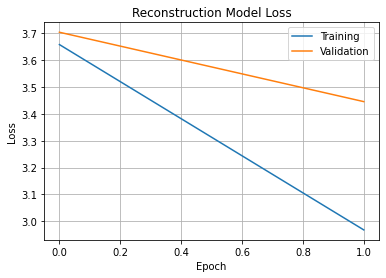

In [19]:
inf_time_start = time.time()

Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model.predict(test_data)

inf_time_stop = time.time()
performance_dict["inference_size"] = 29970
performance_dict["inference_time"] = inf_time_stop - inf_time_start
performance_dict["test_Kloss_model"] = Kloss

print("Koopman loss: %.4f" %Kloss)

print('Psi_X shape:', Psi_X.shape)
print('Psi_Y shape:', Psi_Y.shape)
print('PSI_X shape:', PSI_X.shape)
print('PSI_X shape:', PSI_Y.shape)

# Plot training & validation loss values
validation_plot(history)

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 9.868026936905412
[INFO]: Trace of K_deepDMD: 4.932325963704592
[INFO]: One time-step error with K_deepDMD: 29.547762992117004


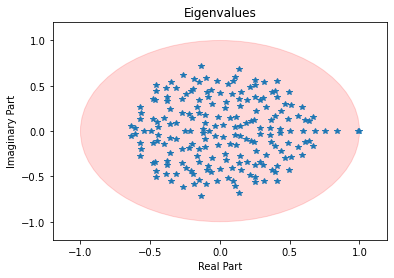

In [20]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)

performance_dict["test_Kloss_calc"] = np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro')
performance_dict["eigen_real"] = list(eigenvaluesK.real)
performance_dict["eigen_imag"] = list(eigenvaluesK.imag)

eigen_plot(eigenvaluesK.real, eigenvaluesK.imag)

In [21]:
K_model.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (DenseLayer)     multiple                  17536     
_________________________________________________________________
dense_layer_1 (DenseLayer)   multiple                  16512     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_layer_2 (DenseLayer)   multiple                  8256      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_layer_3 (DenseLayer)   multiple                  4160      
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0   

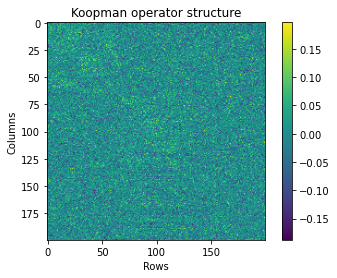

In [22]:
heatmap_matplotlib(K_deepDMD, title='Koopman operator structure')

In [26]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [27]:
import json
with open("performance.json", 'w') as fp:
    json.dump(performance_dict, fp, cls=NpEncoder)